<center><h1>Accident Likelihood Predictive Model</center>
<br>
    
---
   
<b>Objective</b>: Develop a predictive model able to predict whether a driver is going to have a severe or fatal accident given biographical information and vehicle characteristics.

The probability in output of the predictive model can be used as a "Driver Score" highlighting the overall riskiness of a driver.
    
Data: https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data
    
---

## Libraries

In [2]:
import fancyimpute as fi
import interpretableai.iai as ai
import matplotlib as mp
import numpy as np
import pandas as pd
import sklearn.impute as si
import sklearn.linear_model as lm
import sklearn.metrics as sm
import sklearn.model_selection as ms
import xgboost as xg

# Jupyter Plots
mp.rcParams['figure.dpi']= 600
%matplotlib inline

Using TensorFlow backend.


## Data Loading

In [3]:
vehicles = pd.read_csv('Data/Vehicles.csv', low_memory=False)
casualties = pd.read_csv('Data/Casualties.csv', low_memory=False)
accidents = pd.read_csv('Data/Accidents.csv', low_memory=False)

## Exploratory Analysis

### Vehicles

In [43]:
vehicles.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,2018010080971,1,9,0,18,0,0,0,0,0,...,6,1,32,6,1995,2,5,8,1,8
1,2018010080971,2,8,0,18,0,0,0,0,0,...,6,1,48,8,1798,8,6,1,1,1
2,2018010080973,1,9,0,18,0,2,0,0,0,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
3,2018010080974,1,8,0,7,0,8,0,0,0,...,1,1,40,7,1797,8,6,3,1,3
4,2018010080974,2,9,0,18,0,1,0,0,3,...,6,1,21,5,-1,-1,-1,5,1,5


In [44]:
vehicles.describe()

,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,...,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
count,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,...,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000,226409.000000
mean,1.568891,9.997522,0.013197,12.129708,0.131086,2.155714,0.158942,0.261783,0.268677,0.369848,...,4.691170,1.463122,35.517731,5.929424,1443.714751,1.015680,5.726954,3.591779,0.874510,3.591779
std,2.230718,10.909687,0.348416,6.702963,1.166424,3.026446,0.838033,1.600201,1.305326,1.874337,...,1.978297,0.664366,20.795952,3.133560,1638.166987,1.463009,6.086947,3.600298,1.090387,3.600298
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,9.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,23.000000,5.000000,125.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
50%,1.000000,9.000000,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,1.000000,35.000000,6.000000,1398.000000,1.000000,5.000000,3.000000,1.000000,3.000000
75%,2.000000,9.000000,0.000000,18.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2.000000,50.000000,8.000000,1956.000000,2.000000,10.000000,7.000000,1.000000,7.000000
max,999.000000,98.000000,5.000000,18.000000,9.000000,8.000000,5.000000,12.000000,8.000000,11.000000,...,6.000000,3.000000,101.000000,11.000000,99999.000000,12.000000,84.000000,10.000000,3.000000,10.000000


### Casualties

In [45]:
casualties.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2018010080971,1,1,2,2,50,8,3,0,0,2,0,0,9,1,8
1,2018010080971,2,2,1,1,48,8,3,0,0,0,0,0,8,1,1
2,2018010080973,1,1,3,1,29,6,3,5,1,0,0,2,0,1,3
3,2018010080974,1,1,1,1,40,7,3,0,0,0,0,0,8,1,3
4,2018010080981,1,1,1,1,27,6,2,0,0,0,0,0,9,1,7


In [46]:
casualties.describe()

,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
count,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000,160597.000000
mean,1.482232,1.396819,1.496012,1.406141,37.060829,6.345897,2.818932,0.754983,0.596997,0.247072,0.075736,0.085637,7.255279,1.064852,3.966400
std,2.563649,2.698827,0.727561,0.492632,19.657711,2.441757,0.412917,2.123740,1.923275,0.574233,0.523489,0.405104,8.315350,0.934915,3.402589
min,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,1.000000,1.000000,22.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,34.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,4.000000
75%,2.000000,1.000000,2.000000,2.000000,50.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,7.000000
max,999.000000,991.000000,3.000000,2.000000,102.000000,11.000000,3.000000,10.000000,9.000000,2.000000,4.000000,2.000000,98.000000,3.000000,10.000000


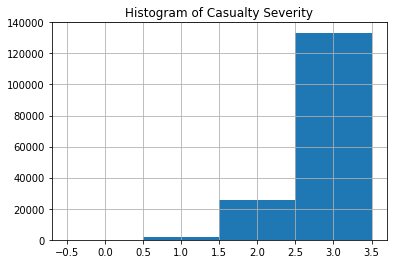

In [47]:
mp.pyplot.title('Histogram of Casualty Severity');
casualties.Casualty_Severity.hist(bins=np.arange(4.5)-0.5);

### Accidents

In [48]:
accidents.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,01/01/2018,...,0,0,4,1,1,0,0,1,1,E01000854
1,2018010080973,542020.0,184290.0,0.046471,51.539651,1,3,1,1,01/01/2018,...,0,0,4,1,1,0,0,1,1,E01003531
2,2018010080974,531720.0,182910.0,-0.102474,51.529746,1,3,2,1,01/01/2018,...,0,5,4,1,1,0,0,1,1,E01002723
3,2018010080981,541450.0,183220.0,0.037828,51.530179,1,2,2,1,01/01/2018,...,0,5,4,2,2,0,0,1,1,E01003492
4,2018010080982,543580.0,176500.0,0.065781,51.469258,1,2,2,2,01/01/2018,...,0,0,4,1,2,0,0,1,1,E01001682


In [49]:
accidents.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,122580.000000,1.225800e+05,122580.000000,122580.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,...,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000,122635.000000
mean,451386.466993,2.827828e+05,-1.264938,52.432318,28.329947,2.783855,1.846202,1.309553,4.098463,327.148220,...,291.798288,-0.004232,0.865381,2.004020,1.616985,1.267118,0.075712,0.046789,1.327019,1.293905
std,95160.136962,1.529706e+05,1.395583,1.377821,24.869499,0.443486,0.721339,0.763476,1.926830,257.396769,...,1129.172587,0.256316,1.994485,1.701349,1.782177,0.596712,0.650032,0.529828,0.470133,0.472232
min,84654.000000,1.023500e+04,-7.266148,49.912362,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,387093.000000,1.758900e+05,-2.193964,51.469092,5.000000,3.000000,1.000000,1.000000,2.000000,85.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,457713.000000,2.234810e+05,-1.147169,51.893531,23.000000,3.000000,2.000000,1.000000,4.000000,305.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,528980.000000,3.885220e+05,-0.140973,53.391034,45.000000,3.000000,2.000000,1.000000,6.000000,512.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.000000,2.000000
max,655275.000000,1.209512e+06,1.758123,60.763722,98.000000,3.000000,24.000000,59.000000,7.000000,941.000000,...,9620.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.000000,7.000000,3.000000,3.000000


### Parameters

In [50]:
PREDICTIVE_FEATURES = ['Vehicle_Type','Towing_and_Articulation','Was_Vehicle_Left_Hand_Drive?', 
                       'Sex_of_Driver', 'Age_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code',
                       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type', 'Vehicle_IMD_Decile']

DESCRIPTIVE_FEATURES = ['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 
                        'Latitude', 'Police_Force',
                        'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 
                        'Day_of_Week', 'Time', 'Local_Authority_(District)', 
                        'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 
                        'Road_Type', 'Speed_limit', 'Junction_Detail', 
                        'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 
                        'Pedestrian_Crossing-Human_Control', 'Carriageway_Hazards', 
                        'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 
                        'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Urban_or_Rural_Area', 
                        'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location',
                        'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location',
                        'Skidding_and_Overturning', 'Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway', 
                        'Hit_Object_off_Carriageway','1st_Point_of_Impact','Journey_Purpose_of_Driver',
                        'Pedestrian_Location', 'Pedestrian_Movement', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
                        'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Casualty_Severity']

CATEGORICAL_FEATURES = ['Vehicle_Type', 'Towing_and_Articulation', 'Sex_of_Driver', 
                        'Propulsion_Code', 'Driver_Home_Area_Type']
BINARY_FEATURES = ['Was_Vehicle_Left_Hand_Drive']

## Data Aggregation

In [51]:
# For each vehicle involved in an accident, select the highest severity (lowest score) experienced by a person
casualties_vehicles = casualties.groupby(['Accident_Index', 'Vehicle_Reference'])['Casualty_Severity'].min().reset_index()
casualties_vehicles

,Accident_Index,Vehicle_Reference,Casualty_Severity
0,2018010080971,1,3
1,2018010080971,2,3
2,2018010080973,1,3
3,2018010080974,1,3
4,2018010080981,1,2
...,...,...,...
137401,2018984115718,2,3
137402,2018984115918,1,3
137403,2018984116018,2,3
137404,2018984116318,1,2


In [52]:
data = vehicles.merge(casualties_vehicles, how='left', on=['Accident_Index', 'Vehicle_Reference'])
data

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Casualty_Severity
0,2018010080971,1,9,0,18,0,0,0,0,0,...,1,32,6,1995,2,5,8,1,8,3.0
1,2018010080971,2,8,0,18,0,0,0,0,0,...,1,48,8,1798,8,6,1,1,1,3.0
2,2018010080973,1,9,0,18,0,2,0,0,0,...,3,-1,-1,-1,-1,-1,-1,-1,-1,3.0
3,2018010080974,1,8,0,7,0,8,0,0,0,...,1,40,7,1797,8,6,3,1,3,3.0
4,2018010080974,2,9,0,18,0,1,0,0,3,...,1,21,5,-1,-1,-1,5,1,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226404,2018984116018,1,9,0,9,0,0,0,0,0,...,1,67,10,998,1,4,-1,3,-1,NaN
226405,2018984116018,2,9,0,15,0,0,1,0,7,...,1,24,5,3000,2,21,-1,3,-1,3.0
226406,2018984116018,3,9,0,2,6,0,0,0,0,...,3,-1,-1,2400,2,5,-1,-1,-1,NaN
226407,2018984116318,1,2,0,18,0,1,1,0,0,...,1,60,9,49,1,10,-1,3,-1,2.0


## Data Cleaning

### Aggregate Unknown and Missing

In [53]:
data['Sex_of_Driver'] = data['Sex_of_Driver'].replace(3, -1)

### Remove NAs

In [54]:
data['Casualty_Severity'].fillna(value = 0, inplace = True)

In [55]:
data = data.replace(-1, np.nan)

### Target Variable Encoding

In [56]:
def severity(x):
    if x in (0.0, 3.0):
        return 0
    else:
        return 1

In [57]:
data['Casualty_Severity'] = data['Casualty_Severity'].apply(severity)

### Ex-Ante Features

In [1]:
# Restrict the dataset to ex-ante features
columns = PREDICTIVE_FEATURES
columns.append('Casualty_Severity')

data = data[columns]

NameError: name 'PREDICTIVE_FEATURES' is not defined

## Feature Engineering

### One-Hot Encoding for Categorical Variables

In [59]:
for c in CATEGORICAL_FEATURES:
    if c in data.columns:
        one_hot = pd.get_dummies(data[c], prefix=c)
        data = data.drop(c, axis=1)
        data = data.join(one_hot)

### Binary Variables Encoding

In [60]:
# Convert 1 and 2 to False and True
for b in BINARY_FEATURES:
    if b in data.columns:
        data[b] = data[b].map({1: 0, 2: 1})
        data[b] = data[b].astype(bool)

## Split Training, Validation and Test

In [61]:
X = data[data.columns[~data.columns.isin(['Casualty_Severity'])]]
y = data['Casualty_Severity']

(train_X, train_y), (test_X, test_y) = ai.split_data('classification', X, y, seed=1)

## Imputation

In [ ]:
lnr = si.KNNImputer()

lnr.fit(train_X)

train_X = lnr.transform(train_X)
test_X = lnr.transform(test_X)

## Modelling

### Logistic Regression Model

In [3]:
model = lm.LogisticRegression()

# Hyperparameters
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'], 
    'max_iter': [1000],
    'class_weight': ['balanced']
}

# Grid Search
clf = ms.GridSearchCV(model, params)

# Model Fit
logit = clf.fit(train_X, train_y)

NameError: name 'lm' is not defined

### Random Forests

In [ ]:
# Logistic Regression Model
model = se.RandomForestClassifier()

# Hyperparameters
params = {
 'max_depth': [10],
 'n_estimators': [100, 1000],
 'class_weight': [{0: 1, 1: 4}]
}

# Grid Search
clf = ms.GridSearchCV(model, params)

# Model Fit
model = clf.fit(train_X, train_y)

### XGBoost

In [ ]:
# Gradient Boosting Model
model = xg.XGBClassifier()

# Hyperparameters
params = {
        'eta': [0.001, 0.01],
        'max_depth': [5, 10],
        'n_estimators': [50, 100, 1000],
        'scale_pos_weight': [1, 14]
        }

# Grid Search
grid = ms.GridSearchCV(model, params)

# Model Fit
xgb = grid.fit(train_X, train_y)

## Performance Evaluation

In [ ]:
predictions_train = model.predict_proba(train_X)[:, 1]
predictions_test = model.predict_proba(test_X)[:, 1]
print('In Sample AUC:', sm.roc_auc_score(train_y, predictions_train))
print('Out of Sample AUC: ', sm.roc_auc_score(test_y, predictions_test))